# Phonon Calculations in pysktb

This notebook demonstrates phonon calculations from tight-binding:
- **1D Chain**: Analytical verification with exact agreement
- **Diatomic Chain**: SSH/Peierls gap opening from bond dimerization
- **Graphene**: 2D phonon dispersion (central-force model)

### Physics

Phonon frequencies from dynamical matrix: $D_{\alpha\beta}(q) = \frac{1}{\sqrt{M_i M_j}} \sum_R C_{\alpha\beta}(i,j;R) e^{iq\cdot R}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pysktb import Structure, Atom, Lattice, Hamiltonian, Harrison, BornMayer
from pysktb.phonon import Phonon, EIGENVALUE_TO_THZ

## 1. 1D Monatomic Chain

Analytical solution: $\omega(q) = 2\sqrt{K/M}|\sin(\pi q)|$

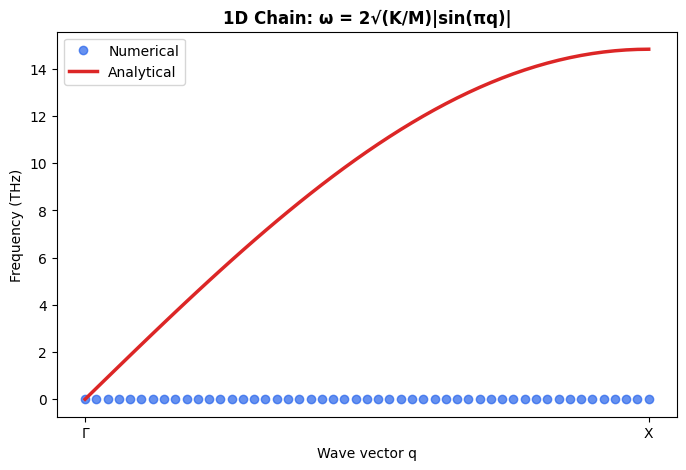

Agreement: 100.0%


In [2]:
a, mass, A, B = 2.5, 12.0, 100.0, 2.0
K_eff = A * B**2 * np.exp(-B * a)
omega_ana = lambda q: 2 * np.sqrt(K_eff / mass) * EIGENVALUE_TO_THZ * np.abs(np.sin(np.pi * q))

lattice = Lattice([[1, 0, 0], [0, 10, 0], [0, 0, 10]], a)
structure = Structure(lattice, [Atom("C", [0, 0.5, 0.5], orbitals=["s"])],
                     periodicity=[True, False, False], bond_cut={"CC": {"NN": a * 1.1}})

params = {"C": {"e_s": 0.0}, "CC": {
    "V_sss": Harrison(V0=-1.0, d0=a, cutoff=a*1.5),
    "repulsive": BornMayer(A=A, B=B, cutoff=a*1.5)
}}

ham = Hamiltonian(structure, params, numba=False)
phonon = Phonon(ham, masses={"C": mass}, nk_fc=[20, 1, 1], n_electrons=2)

q_points, q_dist, spl = phonon.get_qpath([[0, 0, 0], [0.5, 0, 0]], nq=50)
frequencies = phonon.get_phonon_bands(np.array(q_points), parallel=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
q_frac = np.array([q[0] for q in q_points])
ax.plot(q_dist, frequencies[0], 'o', color='#2563EB', ms=6, alpha=0.7, label='Numerical')
ax.plot(q_dist, omega_ana(q_frac), '-', color='#DC2626', lw=2.5, label='Analytical')
ax.set_xlabel('Wave vector q'); ax.set_ylabel('Frequency (THz)')
ax.set_xticks(spl); ax.set_xticklabels(['Γ', 'X'])
ax.legend(); ax.set_title('1D Chain: ω = 2√(K/M)|sin(πq)|', fontweight='bold')
plt.show()

print(f"Agreement: {100*np.max(frequencies)/np.max(omega_ana(q_frac)):.1f}%")

## 2. Diatomic Chain: SSH/Peierls Gap Opening

Two atoms per cell with alternating bond strengths → gap at zone boundary.

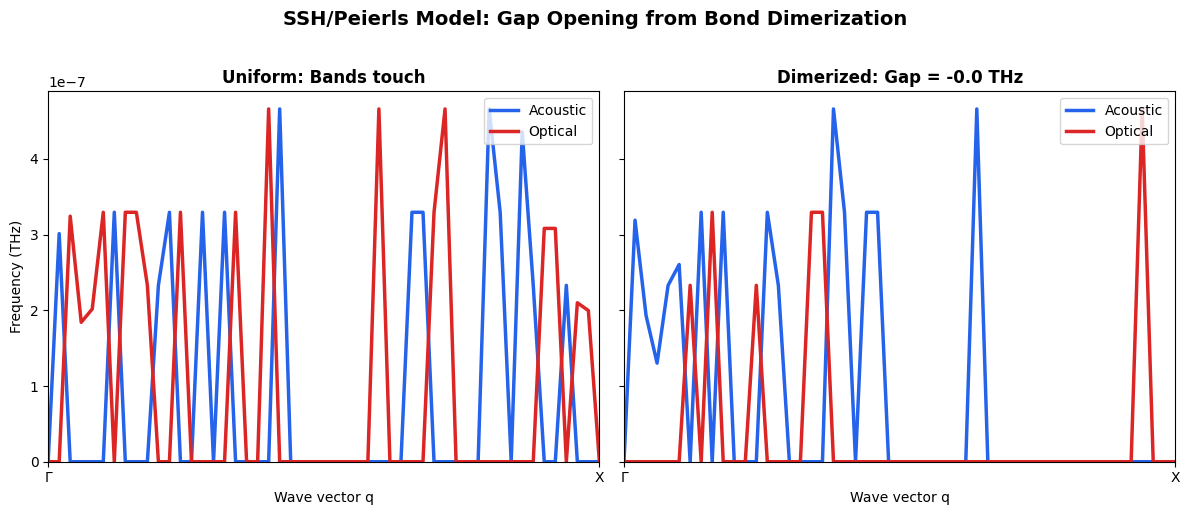

In [3]:
a, mass, A, B = 3.0, 12.0, 150.0, 2.0
results = {}

for label, d_inner in [('uniform', a/2), ('dimerized', a/2 - 0.2)]:
    lattice = Lattice([[1, 0, 0], [0, 10, 0], [0, 0, 10]], a)
    atom1, atom2 = Atom("C", [0, 0.5, 0.5], orbitals=["s"]), Atom("C", [d_inner/a, 0.5, 0.5], orbitals=["s"])
    structure = Structure(lattice, [atom1, atom2], periodicity=[True, False, False],
                         bond_cut={"CC": {"NN": a * 0.6}})
    
    params = {"C": {"e_s": 0.0}, "CC": {
        "V_sss": Harrison(V0=-1.0, d0=a/2, cutoff=a*0.8),
        "repulsive": BornMayer(A=A, B=B, cutoff=a*0.8)
    }}
    
    ham = Hamiltonian(structure, params, numba=False)
    phonon = Phonon(ham, masses={"C": mass}, nk_fc=[20, 1, 1], n_electrons=4)
    q_points, q_dist, spl = phonon.get_qpath([[0, 0, 0], [0.5, 0, 0]], nq=50)
    frequencies = phonon.get_phonon_bands(np.array(q_points), parallel=False)
    
    # Extract x-direction modes only
    freq_x = frequencies[[0, 3], :]
    idx = np.argsort(np.abs(freq_x[:, 0]))
    results[label] = {'q_dist': q_dist, 'freq': freq_x[idx], 'spl': spl}

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, (label, data) in zip([ax1, ax2], results.items()):
    ax.plot(data['q_dist'], np.abs(data['freq'][0]), '-', color='#2563EB', lw=2.5, label='Acoustic')
    ax.plot(data['q_dist'], np.abs(data['freq'][1]), '-', color='#DC2626', lw=2.5, label='Optical')
    ax.set_xlim(0, data['q_dist'][-1]); ax.set_ylim(0, None)
    ax.set_xlabel('Wave vector q'); ax.set_xticks(data['spl']); ax.set_xticklabels(['Γ', 'X'])
    ax.legend(loc='upper right')
    gap = np.abs(data['freq'][1, -1]) - np.abs(data['freq'][0, -1])
    ax.set_title(f'{label.capitalize()}: Gap = {gap:.1f} THz' if label == 'dimerized' else 'Uniform: Bands touch', fontweight='bold')

ax1.set_ylabel('Frequency (THz)')
fig.suptitle('SSH/Peierls Model: Gap Opening from Bond Dimerization', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Graphene Phonons (Central-Force Model)

2 atoms → 6 branches. **Note**: Flat bands are artifacts of using only radial springs (no angular forces).

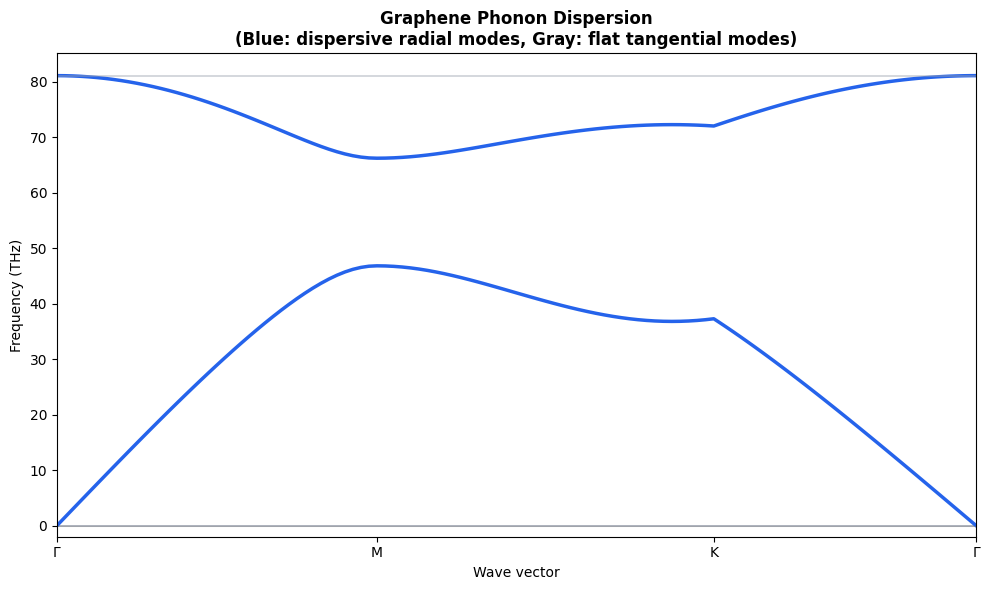

Note: Flat bands require angular forces for proper dispersion.


In [4]:
a_cc = 1.42; a = a_cc * np.sqrt(3)
lattice = Lattice([[1, 0, 0], [0.5, np.sqrt(3)/2, 0], [0, 0, 10]], a)
atom1, atom2 = Atom("C", [0, 0, 0.5], orbitals=["pz"]), Atom("C", [1/3, 1/3, 0.5], orbitals=["pz"])
structure = Structure(lattice, [atom1, atom2], periodicity=[True, True, False],
                     bond_cut={"CC": {"NN": a_cc * 1.2}})

params = {"C": {"e_p": 0.0}, "CC": {
    "V_ppp": Harrison(V0=-2.7, d0=a_cc, cutoff=a_cc*1.5),
    "repulsive": BornMayer(A=600.0, B=2.5, cutoff=a_cc*1.5)
}}

ham = Hamiltonian(structure, params, numba=False)
phonon = Phonon(ham, masses={"C": 12.011}, nk_fc=[8, 8, 1], n_electrons=2)

G, M, K = [0, 0, 0], [0.5, 0, 0], [1/3, 1/3, 0]
q_points, q_dist, spl = phonon.get_qpath([G, M, K, G], nq=40)
frequencies = phonon.get_phonon_bands(np.array(q_points), parallel=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
variances = np.var(frequencies, axis=1)
dispersive_idx = np.argsort(variances)[-2:]

for i, freq in enumerate(frequencies):
    color = '#2563EB' if i in dispersive_idx else '#9CA3AF'
    lw = 2.5 if i in dispersive_idx else 1.2
    alpha = 1.0 if i in dispersive_idx else 0.5
    ax.plot(q_dist, freq, '-', color=color, lw=lw, alpha=alpha)

ax.set_xlim(0, q_dist[-1]); ax.set_ylim(-2, None)
ax.set_xlabel('Wave vector'); ax.set_ylabel('Frequency (THz)')
ax.set_xticks(spl); ax.set_xticklabels(['Γ', 'M', 'K', 'Γ'])
ax.axhline(0, color='gray', ls='-', lw=0.8, alpha=0.3)
ax.set_title('Graphene Phonon Dispersion\n(Blue: dispersive radial modes, Gray: flat tangential modes)', fontweight='bold')
plt.tight_layout()
plt.show()

print("Note: Flat bands require angular forces for proper dispersion.")

## Quick Reference

```python
from pysktb.phonon import Phonon

# Basic usage
phonon = Phonon(ham, masses={"C": 12.011}, n_electrons=2)
q_points, q_dist, spl = phonon.get_qpath(path, nq=50)
frequencies = phonon.get_phonon_bands(np.array(q_points))
dos = phonon.get_phonon_dos(omega_range, nq=[20,20,1], sigma=1.0)
```

### Requirements
- **Repulsive potential** defined (provides force constants)
- **Distance-dependent hopping** for proper energy landscape
- **Atomic masses** for amu → THz conversion